In [1]:
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from IPython.display import Image 
from io import StringIO
import pydotplus

from sklearn.metrics import auc, roc_curve, classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree


Populating the interactive namespace from numpy and matplotlib


## Load dataset

In [2]:
df=pd.read_csv('conversion_data.csv')

In [3]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [4]:

for column in df.columns:
    uniques = sorted(df[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])

country                  4	 ['China', 'Germany', 'UK', 'US']
age                     60	 [17, 18, 19, 20, 21]
new_user                 2	 [0, 1]
source                   3	 ['Ads', 'Direct', 'Seo']
total_pages_visited     29	 [1, 2, 3, 4, 5]
converted                2	 [0, 1]



## Data cleaning- remove outliers

In [5]:
df.loc[df.age>=100]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [6]:
df.age[df.age<100].describe()

count    316198.000000
mean         30.569311
std           8.268958
min          17.000000
25%          24.000000
50%          30.000000
75%          36.000000
max          79.000000
Name: age, dtype: float64

In [7]:
df=df.loc[df.age<100]

## EDA

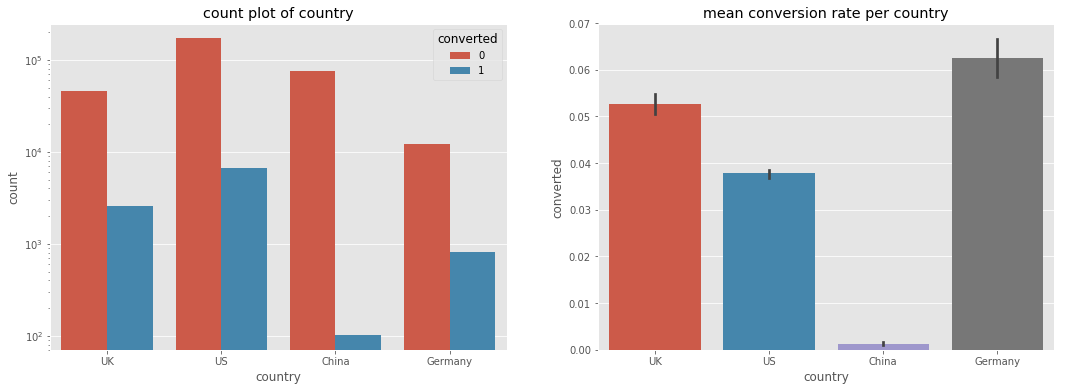

In [8]:
countries=df[['country','converted']].groupby('country').mean().reset_index()

fig, ax=plt.subplots(nrows=1,ncols=2,figsize=(18,6))
sns.countplot(x='country',hue='converted',data=df,ax=ax[0])
ax[0].set_title('count plot of country')
ax[0].set_yscale('log')
sns.barplot(x='country', y='converted',data=df,ax=ax[1])
ax[1].set_title('mean conversion rate per country')
plt.show()

1. It looks like china convert a much lower rate than other countries while it has lots of users.
2. Although Germany has fewer users, It has the highest conversion rate.

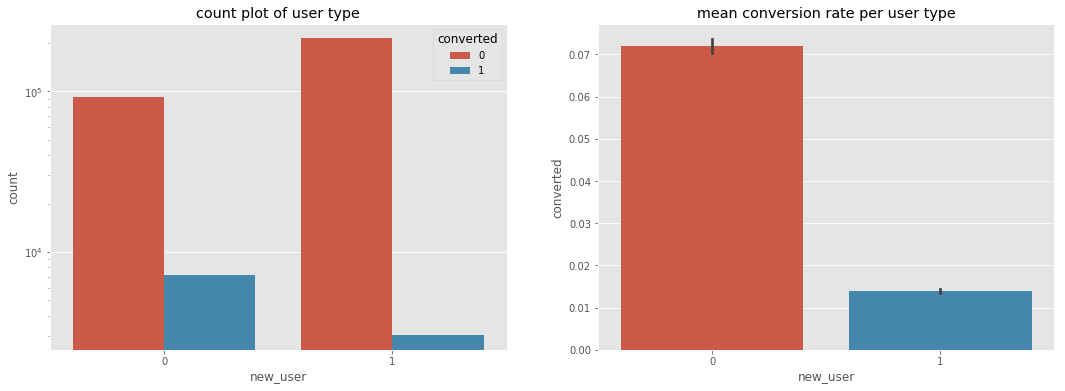

In [9]:
users=df[['new_user','converted']].groupby('new_user').mean().reset_index()

fig, ax=plt.subplots(nrows=1,ncols=2,figsize=(18,6))
sns.countplot(x='new_user',hue='converted',data=df,ax=ax[0])
ax[0].set_title('count plot of user type')
ax[0].set_yscale('log')
sns.barplot(x='new_user', y='converted',data=df,ax=ax[1])
ax[1].set_title('mean conversion rate per user type')
plt.show()

Old users obviously have higher conversion rate than new users although the amount of new users is larger. It means that new users are continously attracted to view the website. We need to figure out which part prevent them from conversion.

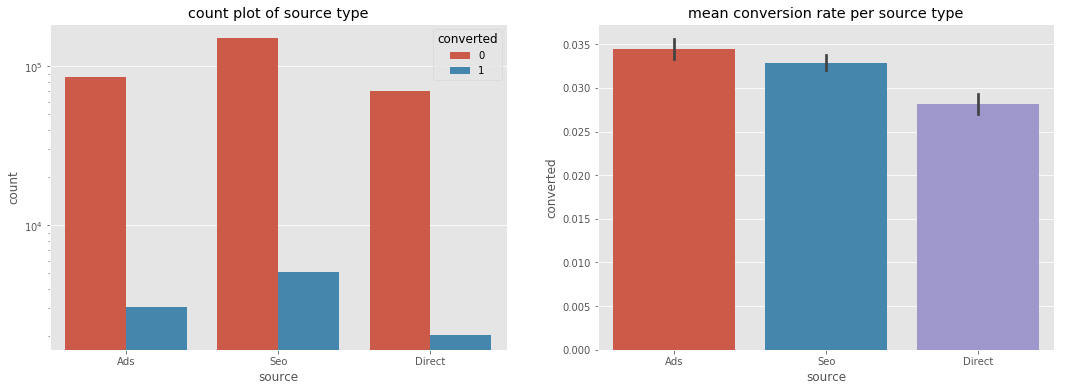

In [10]:
sources=df[['source','converted']].groupby('source').mean().reset_index()

fig, ax=plt.subplots(nrows=1,ncols=2,figsize=(18,6))
sns.countplot(x='source',hue='converted',data=df,ax=ax[0])
ax[0].set_title('count plot of source type')
ax[0].set_yscale('log')
sns.barplot(x='source', y='converted',data=df,ax=ax[1])
ax[1].set_title('mean conversion rate per source type')
plt.show()

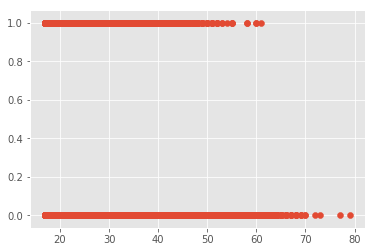

In [11]:
plt.scatter(df.age,df.converted)

Text(0.5,0,'age')

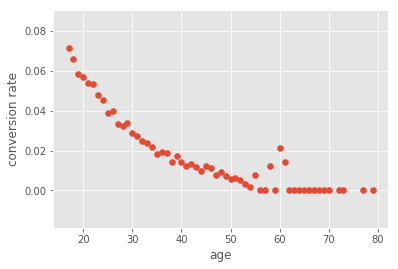

In [12]:
ages=df[['age','converted']].groupby('age').mean().reset_index()
plt.scatter(ages.age,ages.converted)
plt.ylabel('conversion rate')
plt.xlabel('age')

From above plot, we can see there is clearly no 'conversion' from users older than 60. The younger the user is, the higher conversion rate 

Text(0.5,0,'total_pages_visited')

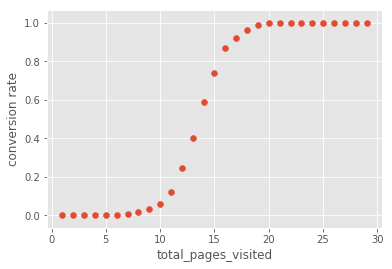

In [13]:
pages=df[['total_pages_visited','converted']].groupby('total_pages_visited').mean().reset_index()
plt.scatter(pages.total_pages_visited,pages.converted)
plt.ylabel('conversion rate')
plt.xlabel('total_pages_visited')

Definitely spending more time on the site implies higher probability of conversion.

## Data Preprocessing

In [9]:
## one-hot-encoding for categorical features
X=df.loc[:,('country', 'age', 'new_user', 'source', 'total_pages_visited')]
X=pd.get_dummies(X)

In [10]:
y=df['converted']
y.mean()

0.03225194340255157

from y's mean(), we know that, target value is very imbalanced, which reminds us should not use plain 'accurancy' as the metric to judge a classifier is good or not

then we need to split the whole dataset into 'training' dataset and 'test' dataset

In [11]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.333,random_state=0)
ytrain.mean(),ytest.mean()

(0.03244604180100899, 0.031863164092920775)

since both ytrain.mean() and ytest.mean() are similar to y.mean(), we can say, the splitting process doesn't import any bias

## Random Forest Classifier

I am going to pick a random forest to predict conversion rate. I pick a random forest cause: it usually
requires very little time to optimize it (its default params are often close to the best ones) and it is strong
with outliers, irrelevant variables, continuous and discrete variables. I will use the random forest to predict
conversion, then I will use its partial dependence plots and variable importance to get insights about how
it got information from the variables. Also, I will build a simple tree to find the most obvious user segments
and see if they agree with RF partial dependence plots.

In [17]:
clf=RandomForestClassifier(n_estimators=10,random_state=0)
clf=clf.fit(Xtrain,ytrain)

In [18]:
print(clf.score(Xtrain,ytrain))
print(clf.score(Xtest,ytest))
print(1-ytest.mean())

0.9883738573000038
0.9841016582141433
0.9681368359070792


In [19]:
ypred=clf.predict(Xtest)
print(classification_report(y_true=ytest,y_pred=ypred))
print(confusion_matrix(y_true=ytest,y_pred=ypred))
fpr,tpr,thresholds=roc_curve(ytest,ypred)
print(auc(fpr,tpr))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    101939
           1       0.80      0.67      0.73      3355

   micro avg       0.98      0.98      0.98    105294
   macro avg       0.89      0.83      0.86    105294
weighted avg       0.98      0.98      0.98    105294

[[101382    557]
 [  1117   2238]]
0.8308000157132047


from above, we know for "label=converted", if we use the default cutoff 0.5, we can have a high precision (0.80), but a not very good recall 0.67, which means we classify 33% converted user as non-converted.

since our task is giving Sales team and Marking team some insights, so we don't need to tune the cutoff value now, since that won't affect the model. however, if, for example, if we care more about not losing a valued customer, so incorrectly classifing a converted user as non-converted will pay much, we need to lower down the cut-off probability to be 1, which will increase the recall with the price lower than precision.

since this is an imbalanced classification problem, if we group every record as 'NOT converted', we can still get 96.81 accuracy (1-ytest.mean()). since our RF model produces an accurancy as 98.41% on test dataset, which indicates it is a model which makes sense.

In [20]:
fi=pd.DataFrame(columns=['feature','importance'])
fi.feature=list(X.columns)
fi.importance=list(clf.feature_importances_)
fi=fi.sort_values(['importance'],ascending=False).reset_index(drop=True)

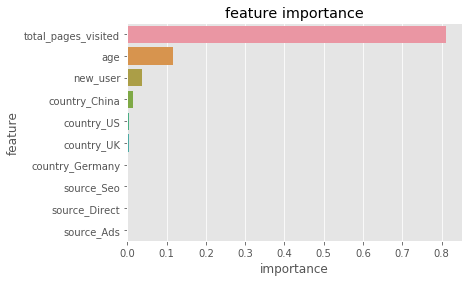

In [21]:
ax=sns.barplot(y=fi.feature,x=fi.importance,data=fi)
ax.set_title('feature importance')
plt.show()

Total pages visited is the most important one, by far. Unfortunately, it is probably the least “actionable”.
People visit many pages cause they already want to buy. Also, in order to buy you have to click on
multiple pages.
Let’s rebuild the RF without that variable. Since classes are heavily unbalanced and we don’t have that
very powerful variable anymore, let’s change the weight a bit, just to make sure we will get something
classified as 1.

In [22]:
X2=X[['age','new_user','country_China','country_Germany','country_UK','country_US','source_Ads','source_Direct','source_Seo']]

Xtrain2,Xtest2,ytrain2,ytest2 = train_test_split(X2,y,test_size=0.333,random_state=0)
ytrain2.mean(),ytest2.mean()

(0.03244604180100899, 0.031863164092920775)

In [23]:
clf2=RandomForestClassifier(n_estimators=10,random_state=0,class_weight='balanced')
clf2=clf2.fit(Xtrain2,ytrain2)

print(clf2.score(Xtrain2,ytrain2))
print(clf2.score(Xtest2,ytest2))
print(1-ytest2.mean())

ypred2=clf2.predict(Xtest2)
print(classification_report(y_true=ytest2,y_pred=ypred2))
print(confusion_matrix(y_true=ytest2,y_pred=ypred2))
fpr,tpr,thresholds=roc_curve(ytest2,ypred2)
print(auc(fpr,tpr))

0.742408868489929
0.7429293217087394
0.9681368359070792
              precision    recall  f1-score   support

           0       0.99      0.74      0.85    101939
           1       0.09      0.74      0.15      3355

   micro avg       0.74      0.74      0.74    105294
   macro avg       0.54      0.74      0.50    105294
weighted avg       0.96      0.74      0.83    105294

[[75753 26186]
 [  882  2473]]
0.7401148394332844


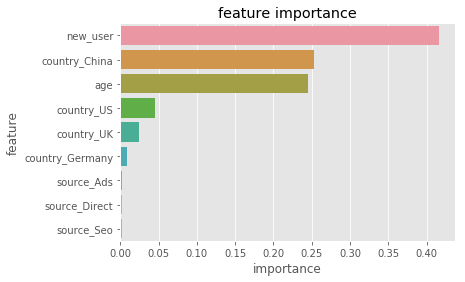

In [24]:
fi=pd.DataFrame(columns=['feature','importance'])
fi.feature=list(X2.columns)
fi.importance=list(clf2.feature_importances_)
fi=fi.sort_values(['importance'],ascending=False).reset_index(drop=True)

ax=sns.barplot(y=fi.feature,x=fi.importance,data=fi)
ax.set_title('feature importance')
plt.show()

New user is the most important one. Source doesn’t seem to matter at all.

In [15]:
clf3=tree.DecisionTreeClassifier()
clf3=clf3.fit(X, y)

def plot_decision_tree(clf,feature_name,target_name):
    #dot_data=StringIO()
    tree.export_graphviz(clf,out_file='tree.dot',
                        feature_names=feature_name,
                        class_names=target_name,
                        filled=True,rounded=True,
                        special_characters=True)
    #graph=pydotplus.graph_from_dot_data(dot_data.getvalue())
    #graph.write_pdf('conversion_rate.pdf')
    #return Image(graph.create_png())
    #when graph is too large, we can't export it as pdf. Instead, we should export as dot
    #input dot -Tpng tree.dot -o tree.png -Gdpi=600    to transform into png and limit max_depth

plot_decision_tree(clf3,X.columns,'converted')

Image(filename='tree.png')

Some conclusions and suggestions:
1. The site is working very well for young users. Definitely let’s tell marketing to advertise and use marketing channel which are more likely to reach young people.
2. The site is working very well for Germany in terms of conversion. But the summary showed that there are few Germans coming to the site: way less than UK, despite a larger population. Again, marketing should get more Germans. Big opportunity.
3. Users with old accounts do much better. Targeted emails with offers to bring them back to the site could be a good idea to try.
4. Something is wrong with the Chinese version of the site. It is either poorly translated, doesn’t fit the local culture, some payment issue or maybe it is just in English! Given how many users are based in China, fixing this should be a top priority. Huge opportunity.
5. Maybe go through the UI and figure out why older users perform so poorly? From 30 y/o conversion clearly starts dropping.
6. If I know someone has visited many pages, but hasn’t converted, she almost surely has high purchase intent. I could email her targeted offers or sending her reminders. Overall, these are probably the easiest users to make convert.

As you can see, conclusions usually end up being about:
1. tell marketing to get more of the good performing user segments
2. tell product to fix the experience for the bad performing ones